In [1]:
import sys
path2oti = '../../../../build/'
sys.path.append(path2oti) # Add path to OTI library.

import pyoti.real   as r
import pyoti.sparse as oti 
import pyoti.core   as coti
import pyoti.fem    as fem 

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
e  = oti.e
np = oti.np

import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})
rc('text', usetex=True)

from stokes_cavity_eq import *

In [2]:
# Load results:
order = 30
pc = 1.0
derivs=['Lx','Ly']
name = "d"+derivs[0]+"_pc"+str(int(pc*100))+"_d"+derivs[1]+"_pc"+str(int(pc*100))+"_n"+str(order)

# Load Velocity field u
u = oti.read("results/"+name+"/u_"+name+".matso")

# Load Pressure field p
p = oti.read("results/"+name+"/pf_o2_"+name+".matso")

In [3]:
# Set OTI algebra and perform perturbations.
fem.set_global_algebra(oti)
alg = fem.get_global_algebra()

hx = 1
hy = 1

Th = fem.square(hx,hy,he=0.01,element_order=2,quads=False,save=False, structured=True)
Th2= fem.square(hx,hy,he=0.01,element_order=2,quads=False,save=False, structured=True)

print(Th)
# move the mesh
Th.x += hx/2
Th.y += hy/2

< mesh (pyoti.sparse) object with 40401 nodes, 20404 elements of types: point1 (4), line3 (400), tri6 (20000) >


/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/numpy/ctypeslib.py:521: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


In [4]:
order = 30
utop = alg.number(1)#+alg.e(2, order = order)
solver = 'umfpack'

# Perturb nodal coordinates for ro
pc = 1.0
xmax = hx
xmin = 0
for i in range(Th.x.size):
    
    x = Th.x[i,0]
    
    if x.real > (xmax-pc*(xmax-xmin)):
        
        h = (1-(xmax-x)/(pc*(xmax-xmin))).real

        Th.x[i,0] = x.real + h*alg.e(1, order = order)
        
    else:
        
        Th.x[i,0] = x.real
    
    # end if 
# end for 

ymax = hy
ymin = 0
for i in range(Th.y.size):
    
    y = Th.y[i,0]
    
    if y.real > (ymax-pc*(ymax-ymin)):
        
        h = (1-(ymax-y)/(pc*(ymax-ymin))).real

        Th.y[i,0] = y.real + h*alg.e(2, order = order)
        
    else:
        
        Th.y[i,0] = y.real
    
    # end if 
    
# end for 

In [5]:
utop = alg.number(1)

solver = 'umfpack'

In [6]:
[ux, uy, pf ],K,f = solve_2d_cavity(Th2, utop, solver=solver)

Setting up problem

Starting elemental computations.

Finished assembly.
Setting up boundary condition.

Ended boundary condition setup.
Starting system solution.

Converted matrix to csr format. - Starting solution process.

Solved problem.


In [7]:
# evaluation point
xpc = 0.4
ypc = 0.9

xsel = -30
ysel = -30
isel=-1
nodes_indx = np.unique(Th.elements[2]['indices'])
for i in nodes_indx:
    i = int(i)
    xval,yval=(Th.x[i,0].real,Th.y[i,0].real)
    xerr = abs(xval-xpc)
    yerr = abs(yval-ypc)
    err = np.sqrt(xerr**2+yerr**2)
    xerrp= abs(xsel-xpc)
    yerrp= abs(ysel-ypc)
    errp = np.sqrt(xerrp**2+yerrp**2)
    
    if err<errp:
        isel=i 
        xsel=xval
        ysel=yval
    # end if 
    

isel,Th.x[isel,0], Th.y[isel,0]

(1730, 0.4000 + 0.4000 * e([1]), 0.9000 + 0.9000 * e([2]))

In [8]:
dx=0.0
dy=0.6

In [9]:
u_eval_oti = u[isel]
p_eval_oti = p[isel,0]
u_eval_oti.taylor_integrate([1,2],[dx,dy]).real, p_eval_oti.taylor_integrate([1,2],[dx,dy]).real

(array([[0.20177116, 0.06229773, 0.        ]]), -1.3405918403765362)

In [10]:
Th2.x = Th.x.taylor_integrate([1,2],[dx,dy])
Th2.y = Th.y.taylor_integrate([1,2],[dx,dy])
[ux, uy, pf ],K,f = solve_2d_cavity(Th2, utop, solver=solver)
pf_o2_ev = convert_to_o2(Th,pf)

u_ev = alg.zeros((ux.shape[0],3))
u_ev[:,0:1] = ux
u_ev[:,1:2] = uy
u_ev[isel].real, pf_o2_ev[isel].real

Setting up problem

Starting elemental computations.

Finished assembly.
Setting up boundary condition.

Ended boundary condition setup.
Starting system solution.

Converted matrix to csr format. - Starting solution process.

Solved problem.


(array([[0.20177107, 0.06229782, 0.        ]]), array([[-1.34057342]]))

In [30]:
Dx = np.linspace( -0.9, 0.9, 9*2*2*2+1 )
Dy = np.linspace( -0.9, 0.9, 9*2*2*2+1 )

Dx, Dy = np.meshgrid(Dx,Dy)
print(Dx.shape)
u_real_ti = np.zeros((Dx.shape[0],Dy.shape[1]))
p_real_ti = np.zeros((Dx.shape[0],Dy.shape[1]))
ii=0
jj=0
for ii in range(Dx.shape[0]):
    for jj in range(Dy.shape[1]):
        
        dx = Dx[ii,jj]
        dy = Dy[ii,jj]
        
        if jj==0:
            print("Evaluation dx={0}/{1}".format(ii,Dx.shape[0]))

        Th2.x = Th.x.taylor_integrate([1,2],[dx,dy])
        Th2.y = Th.y.taylor_integrate([1,2],[dx,dy])
        [ux, uy, pf ],K,f = solve_2d_cavity(Th2, utop, solver=solver, verb=0)
        pf_o2_ev = convert_to_o2(Th,pf)
        u_ev = alg.zeros((ux.shape[0],3))
        u_ev[:,0:1] = ux
        u_ev[:,1:2] = uy

        u_real_ti[ii,jj] = np.linalg.norm(u_ev[isel].real)
        p_real_ti[ii,jj] = pf_o2_ev[isel,0].real

    # end for
# end for

np.save("u_real_ti_200.npy",u_real_ti)
np.save("p_real_ti_200.npy",p_real_ti)
np.save("Dx_200.npy",Dx)
np.save("Dy_200.npy",Dy)





Evaluation dx=0/37
Evaluation dx=1/37
Evaluation dx=2/37
Evaluation dx=3/37
Evaluation dx=4/37
Evaluation dx=5/37
Evaluation dx=6/37
Evaluation dx=7/37
Evaluation dx=8/37
Evaluation dx=9/37
Evaluation dx=10/37
Evaluation dx=11/37
Evaluation dx=12/37
Evaluation dx=13/37
Evaluation dx=14/37
Evaluation dx=15/37
Evaluation dx=16/37
Evaluation dx=17/37
Evaluation dx=18/37
Evaluation dx=19/37
Evaluation dx=20/37
Evaluation dx=21/37
Evaluation dx=22/37
Evaluation dx=23/37
Evaluation dx=24/37
Evaluation dx=25/37
Evaluation dx=26/37
Evaluation dx=27/37
Evaluation dx=28/37
Evaluation dx=29/37
Evaluation dx=30/37
Evaluation dx=31/37
Evaluation dx=32/37
Evaluation dx=33/37
Evaluation dx=34/37
Evaluation dx=35/37
Evaluation dx=36/37


In [140]:
np.min(u_error_ti_est)

0.0

In [118]:
def truncate_var(otivar,ordi):
    var_trunc = otivar.copy()
    var_trunc = var_trunc.truncate([[1,ordi]])
    var_trunc = var_trunc.truncate([[2,ordi]])

    for oo in range(1,ordi):
        o1 = oo
        o2 = ordi-oo
        var_trunc = var_trunc.truncate([[1,o1],[2,o2]])
    
    # end for 
    return var_trunc

In [120]:
u_real_ti = np.load("u_real_ti.npy")
p_real_ti = np.load("p_real_ti.npy")
Dx = np.load("Dx.npy")
Dy = np.load("Dy.npy")

# orders_ti = np.array([30,20,15,10,8,6,4,3,2,1],dtype=np.uint8)
orders_ti = np.array([30,20,15,10,8,6,4,3,2,1],dtype=np.uint8)


u_error_ti = np.zeros((orders_ti.size,Dx.shape[0],Dy.shape[1]))
p_error_ti = np.zeros((orders_ti.size,Dx.shape[0],Dy.shape[1]))
u_error_ti_est = np.zeros((orders_ti.size,Dx.shape[0],Dy.shape[1]))
p_error_ti_est = np.zeros((orders_ti.size,Dx.shape[0],Dy.shape[1]))


kk=0

for ordi in orders_ti:
    print("Eval order :",ordi)
    u_for_ti = u_eval_oti.copy()
    p_for_ti = p_eval_oti.copy()
    # Truncate all ordi + 1 values 
    u_for_ti = u_for_ti.truncate([[1,ordi+1]])
    u_for_ti = u_for_ti.truncate([[2,ordi+1]])
    p_for_ti = p_for_ti.truncate([[1,ordi+1]])
    p_for_ti = p_for_ti.truncate([[2,ordi+1]])
    for oo in range(1,ordi+1):
        o1 = oo
        o2 = ordi+1-oo
        u_for_ti = u_for_ti.truncate([[1,o1],[2,o2]])
        p_for_ti = p_for_ti.truncate([[1,o1],[2,o2]])
    
    # end for 
    
    u2 = truncate_var(u_for_ti,ordi)
    p2 = truncate_var(p_for_ti,ordi)
    
    for ii in range(Dx.shape[0]):
        for jj in range(Dy.shape[1]):
            dx = Dx[ii,jj]
            dy = Dy[ii,jj]
            
#             print("Evaluating: dx={0:.2f}, dy={1:.2f}".format(dx,dy))
           
            u_est = np.linalg.norm(u2.taylor_integrate([1,2],[dx,dy]).real)
            p_est = p2.taylor_integrate([1,2],[dx,dy]).real
            
            u_oti = np.linalg.norm(u_for_ti.taylor_integrate([1,2],[dx,dy]).real) # Magnitude
            p_oti = p_for_ti.taylor_integrate([1,2],[dx,dy]).real            

            u_real = u_real_ti[ii,jj]
            p_real = p_real_ti[ii,jj]

            u_error_ti[kk,ii,jj]=abs( (u_real-u_oti)/(u_real) )
            p_error_ti[kk,ii,jj]=abs( (p_real-p_oti)/(p_real) )
            
            u_error_ti_est[kk,ii,jj] = abs( (u_est-u_oti)/(u_oti) )
            p_error_ti_est[kk,ii,jj] = abs( (p_est-p_oti)/(p_oti) )

        # end for
    # end for
    kk+=1
#     print()
    


Eval order : 30
Eval order : 20
Eval order : 15
Eval order : 10
Eval order : 8
Eval order : 6
Eval order : 4
Eval order : 3
Eval order : 2
Eval order : 1


<IPython.core.display.Javascript object>


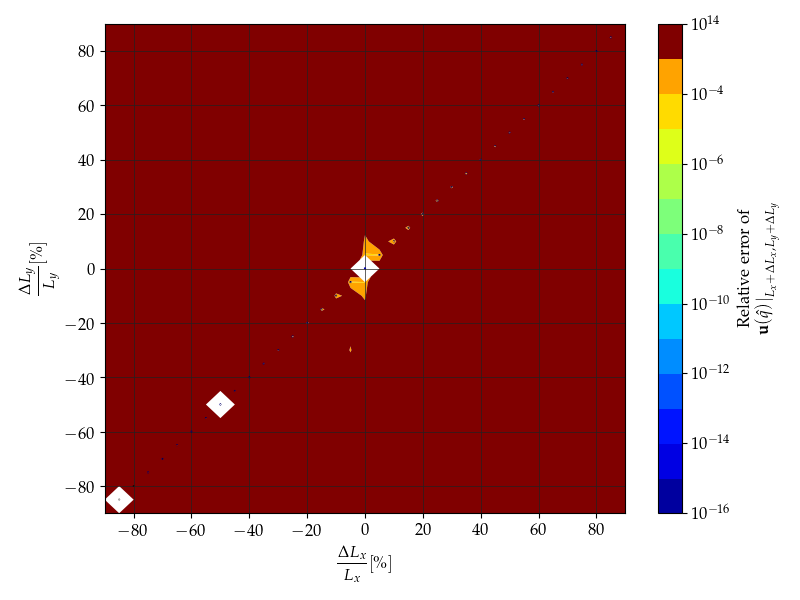

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  # This is added back by InteractiveShellApp.init_path()


In [138]:
from matplotlib.ticker import MultipleLocator
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
from matplotlib import ticker, cm, colors

fig = plt.figure(figsize=(8,6))
lev_exp = np.array([-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,14],dtype=np.float64)
levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())
order_idx=9
# cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levels=16,locator=ticker.LogLocator(10),norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
cp = plt.contourf(100*Dx,100*Dy,u_error_ti[order_idx], levs,antialiased=True, norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
cbar = fig.colorbar(cp)

CS1=plt.contour(100*Dx,100*Dy,u_error_ti[order_idx], [1e-6],colors='b')
CS2=plt.contour(100*Dx,100*Dy,u_error_ti_est[order_idx], [1e-6],colors='k')

plt.clabel(CS1,fmt="%.1e", inline=1, fontsize=10)
# plt.clabel(CS2,fmt="%.1e", inline=0, fontsize=10)

cbar.ax.set_ylabel("Relative error of \n$\\left.\\mathbf{u}(\hat{q})\\right|_{L_x+\Delta L_x,L_y+\Delta L_y}$")
plt.xlabel("$\\displaystyle{\\frac{\Delta L_x}{L_x}} [ \% ]$")
plt.ylabel("$\\displaystyle{\\frac{\Delta L_y}{L_y}} [ \% ]$")


ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(20))
plt.grid(color='#222222', linewidth=0.5)
# plt.axis([-50,50,-100,100])

plt.tight_layout()
plt.savefig('error_ti_Lx_Ly_n'+str(orders_ti[order_idx])+'.pdf',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


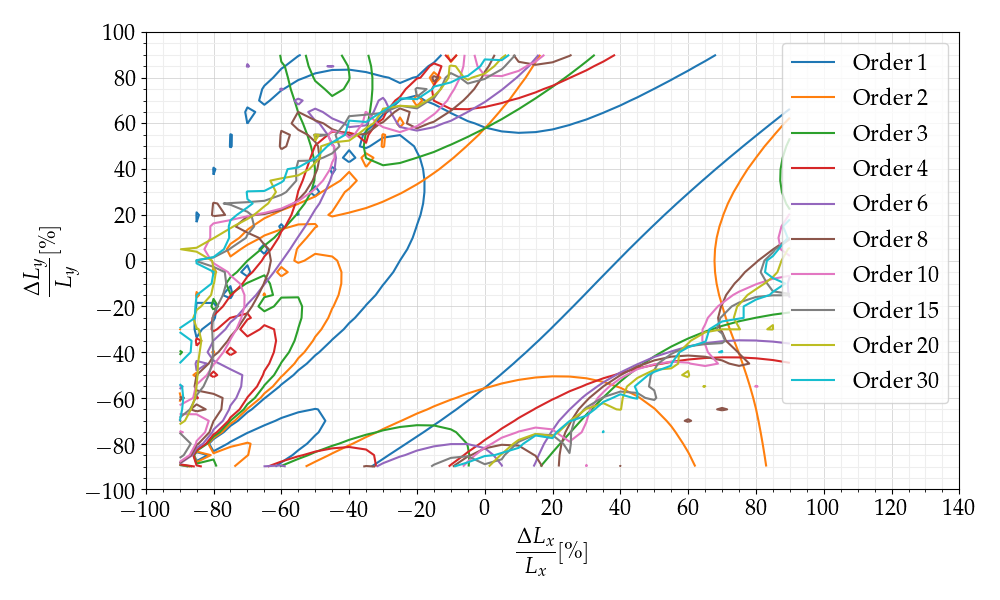

In [113]:
from matplotlib import ticker, cm, colors

rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})
             
fig = plt.figure(figsize=(10,6))
lev_exp = np.array([-7,-6,-5,-4,-3,-2,-1,0,1,2,14],dtype=np.float64)
levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

# cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levels=16,locator=ticker.LogLocator(10),norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
# cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levs,antialiased=True, norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
# cbar = fig.colorbar(cp)
contour_val = 1e-1
for kk in range(len(orders_ti)):
    CS=plt.contour(100*Dx,100*Dy,u_error_ti[-1-kk], [contour_val], colors = 'C'+str(kk))
    
#     plt.clabel(CS,fmt='Order '+str(orders_ti[kk]), inline=1, fontsize=12, colors='k')
#     plt.clabel(CS,fmt='Ord. '+str(orders_ti[-1-kk]), inline=1, fontsize=8, colors='k')
    
    CS.collections[0].set_label('Order '+str(orders_ti[-1-kk]))

# cbar.ax.set_ylabel("Relative error of \n$\\left.\\mathbf{u}(r_o+\\Delta r_o, E+\\Delta E)\\right|_{r_i}$")
plt.xlabel("$\\displaystyle{\\frac{\Delta L_x}{L_x}} [ \% ]$")
plt.ylabel("$\\displaystyle{\\frac{\Delta L_y}{L_y}} [ \% ]$")


ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.grid(which='major',color='#CCCCCC', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')

plt.axis([-100,140,-100,100])
plt.legend()
plt.tight_layout()
plt.savefig('error_ti_Lx_Ly_orders'+str(int(abs(np.log10(contour_val))))+'.pdf',dpi=150)
plt.show()

In [8]:
import pyvista as pv
pv.set_plot_theme("document")

# plotter = pv.Plotter(off_screen=True)
plotter = pv.BackgroundPlotter()
args_cbar = dict(height=0.75, vertical=True, position_x=0.95, 
                 position_y=0.05, title_font_size=100, label_font_size=100)

In [10]:

# plotter = pv.BackgroundPlotter(off_screen=True)
# plotter.set_background("white")
# pv.plotting.rcParams['font']['label_size'] = 40
# pv.plotting.rcParams['font']['title_size'] = 30

grid = Th.to_pv(dims = 2, pd = [u.real], pd_names=[' u  '])

plotter.clear()
plotter.enable_parallel_projection()

plotter.add_mesh(grid, 
           show_edges=False, 
           line_width=2,
           grid = True,
           categories=16,
           cmap='jet', 
           scalar_bar_args=args_cbar
          )
# plotter.add_scalar_bar(height=0.75, 
#                        vertical=True, 
#                        position_x=0.95, 
#                        position_y=0.05, 
#                        interactive=False,
#                        title_font_size=40, 
#                        label_font_size=40)
# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,color='grey', scalar_bar_args=args_cbar)
# p.add_mesh(arrows, lighting=False, stitle="u", scalar_bar_args=args_cbar)
# p.update_coordinates(grid.points + u*factor)

strmline1 = grid.streamlines(
    integration_direction = 'both',
    pointa = (0.5,0,0),
    pointb = (0.5,1,0),   
    n_points = 20
)
strmline2 = grid.streamlines(
    integration_direction = 'both',
    pointa = (0,0,0),
    pointb = (0.1,0.1,0),   
    n_points = 10
)
strmline3 = grid.streamlines(
    integration_direction = 'both',
    pointa = (0.9,0.1,0),
    pointb = (1,0,0),   
    n_points = 10
)

plotter.add_mesh(strmline1, show_edges=False, line_width=1.2,color='gray')
plotter.add_mesh(strmline2, show_edges=False, line_width=1.2,color='gray')
plotter.add_mesh(strmline3, show_edges=False, line_width=1.2,color='gray')
plotter.update_style()
# plotter.enable_image_style()# 
plotter.enable_parallel_projection()


plotter.show_grid(xlabel="x",ylabel="y", font_size=100)

# plotter.show()
plotter.screenshot(filename='test3.jpeg',window_size= [1024*4, 768*4])

In [11]:
plt.figure()

tri = Th.elements[2]['indices'][0][:,:3]

plt.tricontour(Th.x.real.reshape(-1),Th.y.real.reshape(-1),np.linalg.norm(u.real,axis=1).reshape(-1),color='k')
plt.tricontourf(Th.x.real.reshape(-1),Th.y.real.reshape(-1),np.linalg.norm(u.real,axis=1).reshape(-1),cmap='jet')
plt.streamplot(Th.x.real.reshape(-1),Th.y.real.reshape(-1),np.linalg.norm(u[:,0].real).reshape(-1),np.linalg.norm(u[:,1].real).reshape(-1))
plt.axis('equal')
plt.colorbar()

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'color'
  """


ValueError: 'x' values must be equally spaced

In [47]:
np.max(tri)

10600

In [48]:
Th.x.size

40401